<a href="https://colab.research.google.com/github/TrollRider-Kristian/Springboard-AI-Mini-Projects/blob/main/Student_MLE_MiniProject_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project: Deep Learning with Keras

In this mini-project we'll be building a deep learning classifier using Keras to predict income from the popular [Adult Income dataset](http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html).

Predicting income from demographic and socio-economic information is an important task with real-world applications, such as financial planning, market research, and social policy analysis. The Adult dataset, sometimes referred to as the "Census Income" dataset, contains a vast amount of anonymized data on individuals, including features such as age, education, marital status, occupation, and more. Our objective is to leverage this data to train a deep learning model that can effectively predict whether an individual's income exceeds $50,000 annually or not.

Throughout this Colab, we will walk you through the entire process of building a deep learning classifier using Keras, a high-level neural network API that runs on top of TensorFlow. Keras is known for its user-friendly and intuitive interface, making it an excellent choice for both beginners and experienced deep learning practitioners.

Here's a brief outline of what we will cover in this mini-project:

1. **Data Preprocessing:** We will start by loading and exploring the Adult dataset.

2. **Building the Deep Learning Model:** We will construct a neural network using Keras, where we'll dive into understanding the key components of a neural network, including layers, activation functions, and optimization algorithms.

3. **Model Training:** With our model architecture in place, we will split the data into training and validation sets and train the neural network on the training data. We will monitor the training process to prevent overfitting and enhance generalization.

4. **Model Evaluation:** After training, we'll assess the performance of our model on the test dataset.

By the end of this tutorial, you will not only have a functional deep learning classifier for income prediction but also gain valuable insights into how to leverage the power of neural networks for solving real-world classification tasks.


In [1]:
!pip install --upgrade scikeras

In [2]:
# KRISTIAN_NOTE - As of version 1.6.1, Scikit-learn changed their API to look
# for tags from their provided ML algorithms.  Tags provide metadata about the
# algorithm, such as its type (eg. regressor):
# https://scikit-learn.org/stable/developers/develop.html#estimator-tags.
# Here's a StackOverflow article about someone wrapping an XGBoostRegressor in
# a hyperparameter tuning algorithm.  The XGBoostRegressor spits out an error
# due to the lack of a scikit-learn tag:
# https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags
# Here's another article about someone wrapping a KerasClassifier into a
# Grid Search Hyperparameter Tuning algorithm and getting the same error:
# https://stackoverflow.com/questions/79410073/attributeerror-super-object-has-no-attribute-sklearn-tags-when-using-gridse
# Lower versions of scikit-learn do not require the same tag, so the best solution
# is to downgrade the scikit-learn version to 1.5.2:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
# KRISTIAN_NOTE - An 'unresolved imports' warning pops up if we import
# from keras.models / keras.layers.  This is strange because the Google
# Runtime comes bundled with Keras, and the code works accordingly.
# Leave this code commented out for reference purposes:
# from keras.models import Sequential
# from keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
# For visualization of neural network metrics
import seaborn

In [4]:
# Strangely, if we just import keras, we get no warning.
import keras
print (keras.__version__)

3.8.0


You can download the Adult data from the link [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data).

Here are your tasks:

  1. Load the Adult data into a Pandas Dataframe.
  2. Ensure the dataset has properly named columns. If the columns are not read in, assign them by referencing the dataset documentation.
  3. Display the first five rows of the dataset.

In [5]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Download the dataset and load it into a pandas DataFrame
# KRISTIAN_NOTE - The dataset entries for each row are separated
# by commas.  However, the column names are not included in the file,
# but Pandas, by default, treats the first row of data as the column
# names.  Pass header = None to circumvent this, per documentation:
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
adult_df = pd.read_csv (DATA_PATH, header = None)

In [6]:
# KRISTIAN_NOTE - Unfortunately, there's no way to extract the column names from
# the dataset itself.  These names are explicitly listed in the Stanford paper
# that has introduced and discussed this dataset at length:
# https://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf
# 'fnlwgt' stands for 'final weight' or "the number of people the census in the entry represents"
# I named the target column "income-level" because it's categorical (over or under $50K annually)
# Our only option is to add hardcoded column names to this dataframe per
# the ones listed in the dataset. StackOverflow article showing how to do this:
# https://stackoverflow.com/questions/72863835/how-to-create-column-names-in-pandas-dataframe
adult_feature_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income-level",
]
adult_df.columns = adult_feature_names

In [7]:
# Display the first few rows of the DataFrame
print (adult_df.head())

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country income-level  
0          2174             0              40   United-States  

If you're not already familiar with the Adult dataset, it's important to do some exploratory data analysis.

Here are your tasks:

  1. Do exploratory data analysis to give you some better intuition for the dataset. This is a bit open-ended. How many rows/columns are there? How are NULL values represented? What's the percentage of positive cases in the dataset?

  2. Drop all rows with NULL values.

  3. Use Scikit-Learn's [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to convert the `income` column with a data type string to a binary variable.

In [8]:
# Do some exploratory analysis. How many rows/columns are there? How are NULL
# values represented? What's the percentrage of positive cases in the dataset?
print (f"There are: {adult_df.shape [0]} rows and {adult_df.shape [1]} columns in the Adult dataset.")
adult_df["income-level"].value_counts()

There are: 32561 rows and 15 columns in the Adult dataset.


,count
income-level,
<=50K,24720
>50K,7841


24,720 adults, or approximately 76% of the adults, make $50K annually or less. while 7841 make more than this annually.

Interestingly, this data does not handle null values as None or NULL or NaN, but rather as '?', which the isnull() function will not pick up below.

In [9]:
adult_df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


To handle the '?' data, let's print out the column types first.

In [10]:
adult_df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object
sex,object


Now, we get the value_counts for each of the non-integer columns.  We do this because we want to understand ALL the indicators of unknonwn data ('known unknowns' as Rumsfeld would say).
The int64 columns don't have null values because NaN is a null value that the isnull() function above would have picked up.  See the docs: https://pandas.pydata.org/docs/reference/api/pandas.isnull.html

In [11]:
# KRISTIAN_NOTE - Fortunately, all categorical columns except education-num for
# this dataset have a datatype of object.  Therefore, we don't need to
# explicitly state each and every categorical column in a hardcoded array.
for col in adult_df.select_dtypes (include = 'object').columns:
  print (adult_df[col].value_counts())

workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64
marital-status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      

The code above indicates that the only indeterminate value in this dataset is '?'.  Had there been other indeterminate values, like 'N/A' or 'Preferred not to disclose', value_counts() would have picked those up too.

We need to replace every instance of '?' with None and then rerun the isnull() function from above, but we hit a snag in that replacing non-null values with None will not actually change the value to None.  In our case, it just doesn't replace the '?' at all.  See this StackOverflow article: https://stackoverflow.com/questions/17097236/replace-invalid-values-with-none-in-pandas-dataframe

In [12]:
# Leaving in this commented code as a lesson on Pandas replace.
# adult_df.replace (to_replace = '?', value = np.nan, inplace = True)
# print (adult_df.isnull().sum())
# print (adult_df['workclass'].value_counts())

Fortunately the aforementnioned StackOverflow article mentioned another solution.  The read_csv() method can be assigned values to treated as null, so we'll pass '?' and ' ?' as parameters and give this another go.

In [13]:
# Reload the dataset, but pass the na_values parameter to force it to treat '?' as NULL.
# Don't forget to check for leading spaces: https://stackoverflow.com/questions/56825958/why-does-not-work-properly-na-values-in-pandas
adult_df = pd.read_csv (DATA_PATH, header = None, na_values = ['?', ' ?'])
adult_df.columns = adult_feature_names
adult_df.isnull().sum()

,0
age,0
workclass,1836
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,1843
relationship,0
race,0
sex,0


In [14]:
# Find all NULL values and drop them
# Now that we've reloaded the dataset with the '?' value being treated as NULL,
# we can remove those rows in the standard way.
adult_df.dropna (how = 'any', inplace = True)

In [15]:
print (f"There are: {adult_df.shape [0]} rows and {adult_df.shape [1]} columns in the Adult dataset.")
adult_df.isnull().sum()

There are: 30162 rows and 15 columns in the Adult dataset.


,0
age,0
workclass,0
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0


In [16]:
adult_df["income-level"].value_counts()

,count
income-level,
<=50K,22654
>50K,7508


Note that there were 32,561 rows when we loaded the Adult dataset the first time.  There are now 30,162 rows total, and the isnull() method no longer catches any rows including a '?'.  Of these rows, 22,654 people, or roughly 75%, make less than or equal to $50k.

Before we split the training and test data, more EDA is required to understand the distribution of categorical variables.  This allows us to determine how feasible it is to stratify our train-test split so that every member of our test set belongs to categories already taken into account in the training set.

In [17]:
# Use Scikit-Learn's LabelEncoder to convert the income column with a data type
# string to a binary variable.
le_income = LabelEncoder()
adult_df["income-over-50k"] = le_income.fit_transform (adult_df["income-level"])
adult_df_encoded_target = adult_df.drop (labels = "income-level", axis = 1)
print (adult_df_encoded_target.head(10))

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   
5   37            Private  284582     Masters             14   
6   49            Private  160187         9th              5   
7   52   Self-emp-not-inc  209642     HS-grad              9   
8   31            Private   45781     Masters             14   
9   42            Private  159449   Bachelors             13   

           marital-status          occupation    relationship    race  \
0           Never-married        Adm-clerical   Not-in-family   White   
1      Married-civ-spouse     Exec-managerial         Husband   White   
2                Divorced   Handlers-cleaners   Not-in-family   White   
3  

In the previous mini-project (please see Student_MLE_MiniProject_ML.ipynb), I dealt with a dataset of taxi records including id's for locations to pick up and drop off passengers.  When splitting that data, there were three taxi rides in the test set featuring pickup location id's not present in the training set.  Because there were so many distinct location id's, it was impossible to stratify the data.  However, there were so few of these unaccounted offenders that removing them from the test set left almost zero impact on the model.

But I do not find this approach satisfactory.  This test set has only a fraction of the number of rows as the Taxicab dataset from the previous project.  I'd rather deal with this problem a different way.  After having discussed this issue with my mentor, I now know it is common practice to apply one-hot encoding to the dataset before the train-test split step.

However, the ColumnTransformer portion of this project will need to be integrated into the same Pipeline as the Keras model I will be building later in the project, and that Pipeline only takes "transformer" type operations.  Unfortunately, scikit-learn's train-test-split operation is NOT a "transformer" type operation, thereby creating a "chicken and the egg" situation between data splitting and one-hot-encoding.

After a discussion with my mentor, I have decided to do the following:

1. I will use the get_dummies function from Pandas first because it returns a DataFrame that's easy to split.

2. Then, I will train-test-split the dataset.

3. Then, I will measure the effectiveness of a baseline model.

4. Then, I will create the ColumnTransformer, but the OneHotEncoding step will not perform on any columns.  The encoded columns created from step 1) will be preserved as they are.

In [18]:
# KRISTIAN_NOTE - Fortunately, all categorical columns except education-num for
# this dataset have a datatype of object.  Therefore, we don't need to
# explicitly state each and every categorical column in a hardcoded array.
# We need only remove 'income-level' since that's our target before label-encoding.
categorical_feature_cols = list(adult_df.select_dtypes (include = 'object').columns[0:-1])
print (categorical_feature_cols)

# Again, remove 'income-over-50k' since that's our target after label-encoding.
quanitative_feature_columns = list (adult_df.select_dtypes (include = 'int64').columns[0:-1])
print (quanitative_feature_columns)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


STEP 1. Use get_dummies to one-hot encode the data.
Docs: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [19]:
# List out the columns explicitly.
# StackOverflow article for this: https://stackoverflow.com/questions/36285155/pandas-get-dummies
adult_df_converted_cols = pd.get_dummies (adult_df_encoded_target, columns = categorical_feature_cols)
print (adult_df_converted_cols.head())

   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

   income-over-50k  workclass_ Federal-gov  workclass_ Local-gov  \
0                0                   False                 False   
1                0                   False                 False   
2                0                   False                 False   
3                0                   False                 False   
4                0                   False                 False   

   workclass_ Private  ...  native-country_ Portugal  \
0               False  ...                     False   
1               

Now, the DataFrame has 105 columns total: 104 feature columns and our label-encoded target column 'income-over-50k'.

Note that get_dummies one-hot encodes datasets to have boolean columns (eg. True for 'native-country_ Thailand' if the adult is from Thailand and False for the other countries).  Therefore, we can obtain a list of these columns with our trusty 'dtypes' and 'select_dtypes' methods as before.

In [20]:
print (list (adult_df_converted_cols.select_dtypes (include = 'bool')))

['workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Ot

STEP 2. Split the data into training and test sets. Remember not to include the label you're trying to predict, `income`, as a column in your training data.

In [21]:
# Split dataset into training and test sets
features_train, features_test, target_train, target_test = train_test_split (\
  adult_df_converted_cols.drop ('income-over-50k', axis = 1, inplace = False), adult_df_converted_cols['income-over-50k'], random_state = 16,\
)

In machine learning, the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) metric are commonly used to evaluate the performance of binary classification models. These are valuable tools for understanding how well a model can distinguish between the positive and negative classes in a classification problem.

Let's break down each concept:

1. ROC Curve:
The ROC curve is a graphical representation of a binary classifier's performance as the discrimination threshold is varied. It is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at different threshold values. Here's how these rates are calculated:

- True Positive Rate (TPR), also called Sensitivity or Recall, measures the proportion of actual positive instances that are correctly identified by the model:
   TPR = True Positives / (True Positives + False Negatives)

- False Positive Rate (FPR) measures the proportion of actual negative instances that are incorrectly classified as positive by the model:
   FPR = False Positives / (False Positives + True Negatives)

The ROC curve is useful because it shows how well a classifier can trade off between sensitivity and specificity across different threshold values. The ideal ROC curve hugs the top-left corner, indicating a high TPR and low FPR, meaning the classifier is excellent at distinguishing between the two classes.

2. AUC (Area Under the Curve):
The AUC is a scalar metric derived from the ROC curve. It represents the area under the ROC curve, hence its name. The AUC ranges from 0 to 1, where 0 indicates a very poor classifier (always predicting the opposite class) and 1 signifies a perfect classifier (making all correct predictions).

The AUC metric is beneficial because it provides a single value to summarize the classifier's overall performance across all possible threshold values. It is particularly useful when dealing with imbalanced datasets, where one class significantly outnumbers the other. In such cases, accuracy alone might not be a reliable evaluation metric, and AUC can provide a more robust performance measure.

A quick rule of thumb for interpreting AUC values:
- AUC ≈ 0.5: The model performs no better than random guessing.
- 0.5 < AUC < 0.7: The model has poor to fair performance.
- 0.7 < AUC < 0.9: The model has good to excellent performance.
- AUC ≈ 1: The model is close to or has a perfect performance.

STEP 3: Measure the effectiveness of the baseline model.

Here are your tasks:

  1. Use Scikit-Learn's [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) to calculate the AUC score for a method that always predicts the majority class.  

In [22]:
# Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that
# always predicts the majority class.
def always_predicts_majority_baseline (target_col):
  frequencies_list = target_col.value_counts().to_list()
  return frequencies_list.index (max (frequencies_list))

baseline_model = always_predicts_majority_baseline (target_train)
print (f"The baseline model will always predict {baseline_model} for adult income. >= $50k.")
roc_auc_score (target_test, [baseline_model] * len (target_test))

The baseline model will always predict 0 for adult income. >= $50k.


np.float64(0.5)

The area under the curve for our baseline model is 0.5, which means it exactly as useful as random guessing.

Instructions from the Project, preserved for reference purposes (I already one-hot encoded the columns):

STEP 4 - Use MinMaxScaler on the numerical feature columns.

Now, let's do a little feature engineering.

1. Use Scikit-Learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply One Hot Encoding to the categorical variables in `workclass`, `education`, `marital-status`, `occupation`, `relationship`, 'race', `sex`, and `native-country`. Also, apply [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to the remaining continuous features. How many columns will the dataframe have after these columns transformations are applied?

In [23]:
# Use Scikit-Learn's ColumnTransformer to apply One Hot Encoding to the
# categorical variables in workclass, education, marital-status, occupation,
# relationship, 'race', sex, and native-country.
# KRISTIAN_NOTE - Actually, we'll apply a FunctionTransformer to preserve the categorical columns we've already one-hot encoded via an identity function.
# Why? Because the ColumnTransformer returns a concactenation of only the columns on which it has operated.
# See StackOverflow: https://stackoverflow.com/questions/68869466/use-sklearn-transformers-on-list-of-columns-and-preserve-the-input-columns

print (f'There are {features_train.shape[1]} total columns in the training set.')

all_columns_preparer = ColumnTransformer ([\
  # KRISTIAN_NOTE - Don't one-hot encode the columns a second time.
  ('one_hot_categorical_columns', OneHotEncoder (handle_unknown = 'error'), []), #, categorical_feature_cols),
  ('preserve_categorical_columns', FunctionTransformer (lambda x: x), list (features_train.select_dtypes (include = 'bool'))),
  ('scale_quantifiable_columns', MinMaxScaler (), quanitative_feature_columns)
])

There are 104 total columns in the training set.


In [24]:
# How many columns will the dataframe have after these columns transformations are applied?
# KRISTIAN_NOTE - We already dropped the target 'income-over-50k' column via the label-encoding above.
# Also, keep in mind the result is NOT a dataframe, but a sparse matrix.
encoded_adult_sparse_matrix = all_columns_preparer.fit_transform (features_train, target_train)
print (f"Number of rows in one-hot encoded adult dataset: {encoded_adult_sparse_matrix.shape[0]}")
print (f"Number of columns in one-hot encoded adult dataset: {encoded_adult_sparse_matrix.shape[1]}")

Number of rows in one-hot encoded adult dataset: 22621
Number of columns in one-hot encoded adult dataset: 104


Same number of columns as before minus the target column (104 total), so that checks out.

Keras is an open-source deep learning library written in Python. It was developed to provide a user-friendly, high-level interface for building and training neural networks. The library was created by François Chollet and was first released in March 2015 as part of the Deeplearning4j project. Later, it became part of the TensorFlow ecosystem and is now the official high-level API for TensorFlow.

Keras is designed to be modular, user-friendly, and easy to extend. It allows researchers and developers to quickly prototype and experiment with various deep learning models. One of the primary goals of Keras is to enable fast experimentation, making it simple to build and iterate on different architectures.

Key features of Keras include:

1. User-friendly API: Keras provides a simple and intuitive interface for defining and training deep learning models. Its design philosophy focuses on ease of use and clarity of code.

2. Modularity: Models in Keras are built as a sequence of layers, and users can easily stack, merge, or create complex architectures using a wide range of predefined layers.

3. Extensibility: Keras allows users to define custom layers, loss functions, and metrics. This flexibility enables researchers to experiment with new ideas and algorithms seamlessly.

4. Backends: Initially, Keras supported multiple backends, including TensorFlow, Theano, and CNTK. However, as of TensorFlow version 2.0, TensorFlow has become the primary backend for Keras.

5. Multi-GPU and distributed training: Keras supports training models on multiple GPUs and in distributed computing environments, making it suitable for large-scale experiments.

6. Pre-trained models: Keras includes a collection of pre-trained models for common tasks, such as image classification (e.g., VGG, ResNet, MobileNet) and natural language processing (e.g., Word2Vec, GloVe).

The integration of Keras into TensorFlow as its official high-level API has solidified its position as one of the most popular deep learning libraries in the machine learning community. Its ease of use and versatility have contributed to its widespread adoption in both academia and industry for a wide range of deep learning tasks.

Here are your tasks:

1. Create your own model in Keras to predict income in the Adult training data. Remember, it's always better to start simple and add complexity to the model if necessary. What's a good loss function to use?

2. Keras can be integrated with Scitkit-Learn using a wrapper. Use the [KerasClassifier wrapper](https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html) to integrate your Keras model with the ColumnTransformer from previous steps using a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object.

3. Fit your model.

4. Calculate the AUC score of your model on the test data. Does the model predict better than random?

5. Generate an ROC curve for your model using [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html). What would the curve look like if all your predictions were randomly generated? What would the curve look like if it you had a perfect model?

In [25]:
# Define the Keras model
simple_nn = keras.models.Sequential()
# According to the docs: https://keras.io/api/layers/core_layers/input/
# the shape of an Input layer indicates "batches of [n]-dimensional vectors",
# where n is the number of features/columns in the dataset.
# For simplicity, we will not add an activation function to the neural network.
simple_nn.add (keras.layers.InputLayer (shape = (features_train.shape[1], )))
simple_nn.add (keras.layers.Dense (1, activation = 'sigmoid')) # Output layer

# KRISTIAN_NOTE - Need to compile this model before passing it into the Keras Classifier.
# The Pipeline below requires a compiled model or else it will spit out an error
# when you try to fit it to the training data.
simple_nn.compile (\
  # KRISTIAN_NOTE - See below for explanation of why I chose 'adam' below.
  optimizer = 'adam',\
  # KRISTIAN_NOTE - We are dealing with binary categories in our dataset, so
  # binary cross-entropy is a reliable loss function here.
  loss = 'binary_crossentropy',\
  # KRISTIAN_NOTE - Since we're going to make a ROC curve from this model later,
  # we don't need any metrics, but I'd still like to track false positives and
  # false negatives to visualize later.
  metrics = ['false_positives', 'false_negatives'])

Begin with the simplest neural network permissible for this model: an Input layer with one neuron per feature fanning into a single output neuron.  In other words, it's a weighted sum of feature correlations each expressed as a weight and a bias.

Before we proceed, allow me to share what I've learned about optimizers thus far.  It all started with this article: https://www.geeksforgeeks.org/intuition-behind-adagrad-optimizer/

Quote:
"The most significant advantage of Adagrad is its ability to adapt the
learning rate for each parameter. This is especially beneficial when dealing
with sparse features..."

"The most significant advantage of Adagrad is its ability to adapt the
learning rate for each parameter. This is especially beneficial when dealing
with sparse features..."  In our case, one-hot encoding the categorical columns induces a lot of 'sparse-ness' into our data because most of the features will be 0 for each row.  If there are, for instance, 42 possible nationalities per adult, then 41 of those columns will be 'False' or '0' because an adult can only be born in a single location.  Same logic applies for gender, career, marital status, etc...
However, over each epoch, the l2-norm (square root of the sum of the squared gradients) accumulates, and the learning rate is divided by that amount.  After just a few epochs, the model's performance will hit a plateau and not improve any further.

This Medium article: https://medium.com/@brijesh_soni/understanding-the-adagrad-optimization-algorithm-an-adaptive-learning-rate-approach-9dfaae2077bb

suggests a few other algorithms: 'Adadelta' and 'Rmsprop' both involve a sort of 'decay' term to control the rate at which the learning rate shrinks.  However, 'Adam' seems the most sophisticated of the three.

https://www.geeksforgeeks.org/adam-optimizer/
The ADAM optimizer expresses the change in the learning rate, or 'momentum' as a spectrum between zero (learning rate doesn't change) and the gradient of the loss function.
The formulas come down to:

1) new_momentum = (momentum_constant) * old_momentum + (1 - momentum_constant) * (gradient)

2) new_weight = old_weight - (learning_rate * new_momentum)

Intuitively, these formulas remind me of velocity and acceleration in free-fall physics:

1*) new_velocity = old_velocity + (acceleration * time_squared)

2*) new_position = old_position + (new_velocity * time)

Instead of positions, we have weights.  Think of the learning rate as the 'velocity' of the weights in formula 2).  The gradient of the loss function in formula 1) serves as a sort of 'acceleration' to our gradient descent (with a constant instead of time_squared, this is where the analogy ends).

I also noticed that formula 1) is the same expression (with different terms) used for linear interpolation in computer graphics!  https://en.wikipedia.org/wiki/Linear_interpolation

This serves a 'spectrum' for the change or 'acceleration' in the learning rate between zero (learning rate doesn't change) and the gradient of the loss function (the previous step was completely wrong)

If this loss is small, then that signals to the model, "hey, we're on the right track, keep doing what you're doing".  The momentum will be about the same as last time, so the learning rate will change about as much as it did in the previous step.

On the other hand, if the gradient of the loss function is large, then that signals to the model, "this is the real correct gradient descent, change course now", so 'acceleration' will be large, and the momentum will change dramatically to reflect the direction of this new gradient.

For our simple model, let's put the ADAM optimizer to the test.

In [26]:
# Create a Keras classifier
# Keep it simple for now, 20 epochs and batch size 5.
num_epochs = 20
num_batches = 5
# KRISTIAN_NOTE - If I explicitly feed History into the KerasClassifier, the
# pipeline complains.  Could be helpful if I were to fit on the model itself
# rather than the pipeline though.
# simple_history = keras.callbacks.History()

# Don't forget to restate the 'loss' as 'binary_crossentropy' for the KerasClassifier.
simple_model = KerasClassifier (\
  model = simple_nn,\
  epochs = num_epochs,
  batch_size = num_batches,
  loss = 'binary_crossentropy',
  # KRISTIAN_NOTE - Here is a raised GitHub issue confirming what I faced:
  # https://github.com/keras-team/keras/issues/20212
  # And a StackOverflow article too:
  # https://stackoverflow.com/questions/68456592/why-model-fit-result-not-representing-the-same-value-while-printing-the-histor
  # The loss displayed in the pipeline fit call does not, by default, match
  # the loss stored in the history_ callback of the model unless I set verbose
  # to 2.  This is because the default displayed loss represents the mean loss
  # DURING the epoch whereas the loss stored in history_ represents the loss at
  # the END of the epoch.  I have no reason to prefer the former over the latter.
  verbose = 2
  # callbacks = [simple_history]
)

In [27]:
# Create the scikit-learn pipeline
simple_pipeline = Pipeline ([\
  ('all_columns_preparer', all_columns_preparer),\
  ('income_predictor_model', simple_model)])

In [28]:
# Fit the pipeline on the training data
simple_pipeline_callback = simple_pipeline.fit (features_train, target_train)

Epoch 1/20
4525/4525 - 9s - 2ms/step - false_negatives: 3446.0000 - false_positives: 841.0000 - loss: 0.4119
Epoch 2/20
4525/4525 - 8s - 2ms/step - false_negatives: 2594.0000 - false_positives: 1186.0000 - loss: 0.3632
Epoch 3/20
4525/4525 - 10s - 2ms/step - false_negatives: 2503.0000 - false_positives: 1213.0000 - loss: 0.3544
Epoch 4/20
4525/4525 - 10s - 2ms/step - false_negatives: 2435.0000 - false_positives: 1222.0000 - loss: 0.3491
Epoch 5/20
4525/4525 - 7s - 1ms/step - false_negatives: 2392.0000 - false_positives: 1244.0000 - loss: 0.3453
Epoch 6/20
4525/4525 - 7s - 2ms/step - false_negatives: 2395.0000 - false_positives: 1229.0000 - loss: 0.3422
Epoch 7/20
4525/4525 - 13s - 3ms/step - false_negatives: 2371.0000 - false_positives: 1206.0000 - loss: 0.3394
Epoch 8/20
4525/4525 - 13s - 3ms/step - false_negatives: 2329.0000 - false_positives: 1225.0000 - loss: 0.3374
Epoch 9/20
4525/4525 - 15s - 3ms/step - false_negatives: 2317.0000 - false_positives: 1227.0000 - loss: 0.3355
Epoch 

<Axes: xlabel='Epoch #', ylabel='Loss Value'>

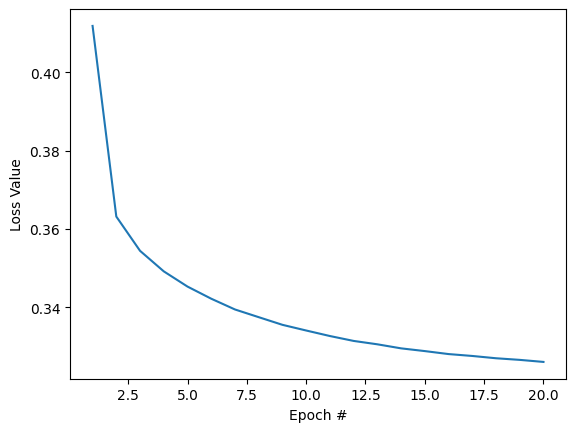

In [29]:
# Represent the loss after each epoch in a linegraph.
# Pipelines retain an instance of each of the objects in their named_steps:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
loss_per_epoch = simple_pipeline_callback.named_steps['income_predictor_model'].history_['loss']
loss_df = {'Epoch #': [i+1 for i in range (num_epochs)], 'Loss Value': loss_per_epoch }
seaborn.lineplot (data = pd.DataFrame (loss_df), x = 'Epoch #', y = 'Loss Value')

<Axes: xlabel='Epoch #', ylabel='False Values'>

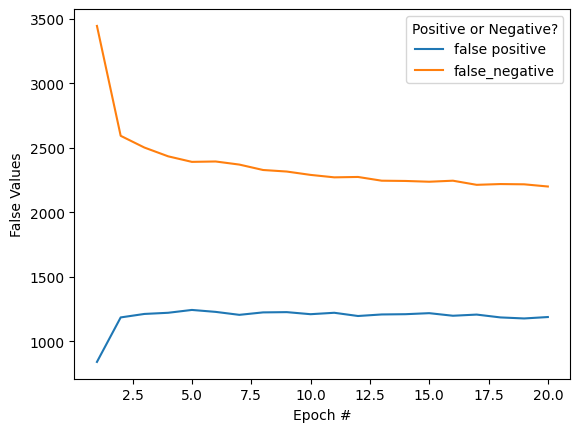

In [30]:
# Represent the number of false positives and false negatives per epoch in a linegraph.
false_positives_per_epoch = simple_pipeline_callback.named_steps['income_predictor_model'].history_['false_positives']
false_negatives_per_epoch = simple_pipeline_callback.named_steps['income_predictor_model'].history_['false_negatives']
line_indicator = ['false positive' for i in range (num_epochs)]\
  + ['false_negative' for i in range (num_epochs)]
false_values_df = {\
  'Epoch #': [i+1 for i in range (num_epochs)] * 2,\
  'False Values': false_positives_per_epoch + false_negatives_per_epoch,\
  'Positive or Negative?': line_indicator
}
seaborn.lineplot (data = false_values_df,\
  x = 'Epoch #', y = 'False Values', hue = 'Positive or Negative?')

In [32]:
# Calculate the AUC score of your model on the test data.
# Does the model predict better than random?
predictions = simple_pipeline.predict (features_test)
roc_auc_score (target_test, predictions)

1509/1509 - 1s - 926us/step


np.float64(0.7655963587476162)

Even our basic neural network performs FAR better than our baseline!  The area under the ROC scores between 0.75-0.77 (each run varies in that range, as opposed to 0.5 for random guessing).  The number of false negatives decreased gradually to convergence over all 20 epochs, but the number of false positives started low, rose dramatically in the second epoch, and slowly converged over the remaining 18 epochs.

A perfect AUC score equals 1, meaning a model reaches 100% accuracy for its training data regardless of the internal threshold the model sets to classify each adult's income (0 or 1).

We still have ways to go.  Let us try a model with a more sophisticated neural network topology.

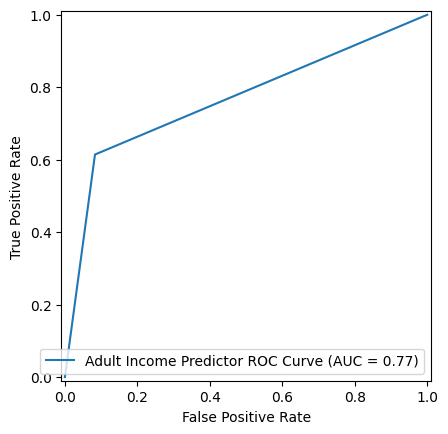

In [33]:
# Generate an ROC curve for your model.
false_positive_rate, true_positive_rate, thresholds = roc_curve (target_test, predictions)
draw_my_curve = RocCurveDisplay (\
  fpr = false_positive_rate,\
  tpr = true_positive_rate,\
  roc_auc = auc (false_positive_rate, true_positive_rate),\
  estimator_name = "Adult Income Predictor ROC Curve")
draw_my_curve.plot()

A ROC curve with an AUC of 1 would look like the top left corner of a perfect square with a straight vertical line going from (0.0, 0.0) to (0.0, 1.0) and a straight horizontal line going from (0.0, 1.0) to (1.0, 1.0).  The curve in question would resemble a perfect square because that's the only curve in this graph that would have an area of 1.

In [346]:
# Define the Keras model
autoencoder_model = keras.models.Sequential()
# KRISTIAN_NOTE - Consecutive input pairs.
# Think of this as an input layer on the set of possible feature-pairs.
autoencoder_model.add (keras.layers.InputLayer (shape = (features_train.shape[1], )))
autoencoder_model.add (keras.layers.Dense (features_train.shape[1]))
# Sparse Autoencoder-esque Layer
autoencoder_model.add (keras.layers.Dense (features_train.shape[1] * 2, activation = 'relu'))
autoencoder_model.add (keras.layers.Dense (features_train.shape[1]))
# Output Layer
autoencoder_model.add (keras.layers.Dense (1, activation = 'sigmoid'))

# Need to compile this model before passing it into the Keras Classifier.
# The Pipeline below requires a compiled model or else it will spit out an error
# when you try to fit it to the training data.
autoencoder_model.compile (\
  optimizer = 'sgd',\
  loss = 'binary_crossentropy',\
  metrics = ['false_negatives', 'false_positives'])

This second neural network is inspired by Karvonen's explanation of sparse autoencoders in this article: https://adamkarvonen.github.io/machine_learning/2024/06/11/sae-intuitions.html

I start with an input layer with the same number of neurons as there are feature columns in the dataset.  But I add an identical Dense layer right after it.  Since each of the neurons in the second layer is connected to every neuron in the Input layer, each neuron in this layer is analogous to the Output node from the previous neural network minus the 'sigmoid' activation function.  In other words, a weighted sum of feature correlations flows from the previous layer flows into EACH neuron of the second layer.

Our first two layers are a weighted sum of weighted sums of feature correlations flowing into the autoencoder-inspired layer.



In [347]:
# Create a Keras classifier
# KRISTIAN_NOTE - Use more epochs than in the previous model, since a more
# complex neural network takes longer to run to convergence.
# Use a larger batch size to keep the neural network training fast and prevent overfitting.
# Same as the last model, declare binary cross-entropy as the loss and set verbose to 2.
adult_income_autoencoder = KerasClassifier (\
  model = autoencoder_model, epochs = num_epochs * 5, batch_size = num_batches * 3,\
  loss = 'binary_crossentropy', verbose = 2)

Note that we are running 100 epochs this time.

In [348]:
# Create the scikit-learn pipeline
autoencoder_pipeline = Pipeline ([\
  ('all_columns_preparer', all_columns_preparer),\
  ('income_predictor_model', adult_income_autoencoder)])

In [349]:
# Fit the pipeline on the training data
autoencoder_pipeline_callback = autoencoder_pipeline.fit (features_train, target_train)

Epoch 1/100
1509/1509 - 4s - 2ms/step - false_negatives: 3217.0000 - false_positives: 1123.0000 - loss: 0.4077
Epoch 2/100
1509/1509 - 6s - 4ms/step - false_negatives: 2517.0000 - false_positives: 1291.0000 - loss: 0.3631
Epoch 3/100
1509/1509 - 4s - 3ms/step - false_negatives: 2411.0000 - false_positives: 1295.0000 - loss: 0.3532
Epoch 4/100
1509/1509 - 3s - 2ms/step - false_negatives: 2367.0000 - false_positives: 1339.0000 - loss: 0.3481
Epoch 5/100
1509/1509 - 6s - 4ms/step - false_negatives: 2310.0000 - false_positives: 1342.0000 - loss: 0.3448
Epoch 6/100
1509/1509 - 3s - 2ms/step - false_negatives: 2277.0000 - false_positives: 1339.0000 - loss: 0.3417
Epoch 7/100
1509/1509 - 5s - 3ms/step - false_negatives: 2259.0000 - false_positives: 1358.0000 - loss: 0.3400
Epoch 8/100
1509/1509 - 3s - 2ms/step - false_negatives: 2268.0000 - false_positives: 1362.0000 - loss: 0.3382
Epoch 9/100
1509/1509 - 4s - 3ms/step - false_negatives: 2262.0000 - false_positives: 1350.0000 - loss: 0.3370
E

<Axes: xlabel='Epoch #', ylabel='Loss Value'>

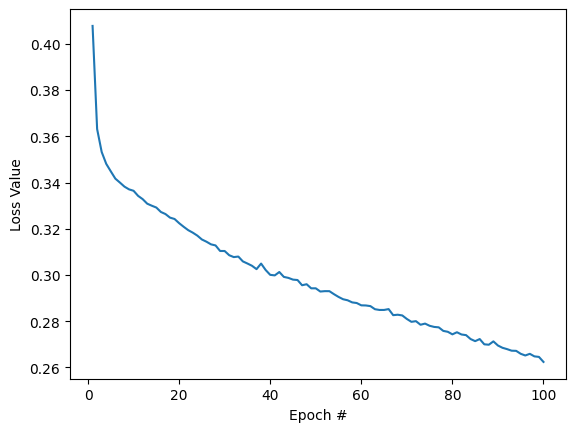

In [352]:
# Just like with the previous model, plot the loss value at the end of each epoch.
autoencoder_losses = autoencoder_pipeline_callback.named_steps['income_predictor_model'].history_['loss']
# This time, we ran the model over 100 epochs.
loss_df = {'Epoch #': [i+1 for i in range (num_epochs * 5)], 'Loss Value': autoencoder_losses }
seaborn.lineplot (data = pd.DataFrame (loss_df), x = 'Epoch #', y = 'Loss Value')

<Axes: xlabel='Epoch #', ylabel='False Values'>

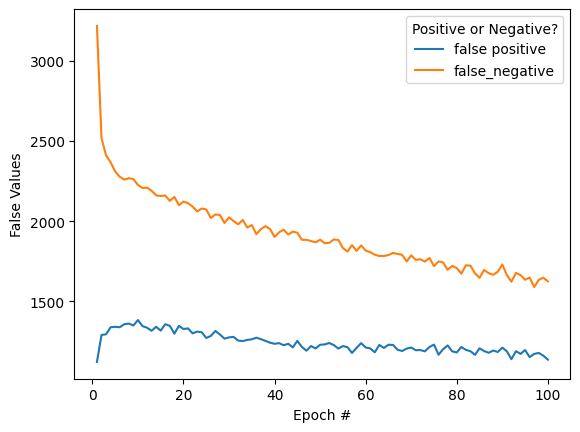

In [353]:
# Represent the number of false positives and false negatives per epoch in a linegraph.
autoencoder_false_positives = autoencoder_pipeline_callback.named_steps['income_predictor_model'].history_['false_positives']
autoencoder_false_negatives = autoencoder_pipeline_callback.named_steps['income_predictor_model'].history_['false_negatives']
another_line_indicator = ['false positive' for i in range (num_epochs * 5)]\
  + ['false_negative' for i in range (num_epochs * 5)]
autoencoder_false_values_df = {\
  'Epoch #': [i+1 for i in range (num_epochs * 5)] * 2,\
  'False Values': autoencoder_false_positives + autoencoder_false_negatives,\
  'Positive or Negative?': another_line_indicator
}
seaborn.lineplot (data = autoencoder_false_values_df,\
  x = 'Epoch #', y = 'False Values', hue = 'Positive or Negative?')

Even after 100 epochs, the number of false positives and false negatives continue to vascillate, but less and less towards the final epoch.  There is a gradual decrease in both even with the vascillations taken to account.

In [350]:
# Calculate the AUC score of your model on the test data.
# Does the model predict better than random?
predictions = autoencoder_pipeline.predict (features_test)
roc_auc_score (target_test, predictions)

503/503 - 1s - 1ms/step


np.float64(0.7902314203759505)

My autoencoder-inspired neural network performs with mixed results with AUC values ranging up to 0.81 with most (but not all) results yielding an AUC above 0.74.  My latest run yields an AUC of 0.79.  This is because it uses Stochastic Gradient Descent as its optimizer instead of Adam.  The fixed learning rate makes the model less consistent but with the potential to outperform Adam under the right circumstances.

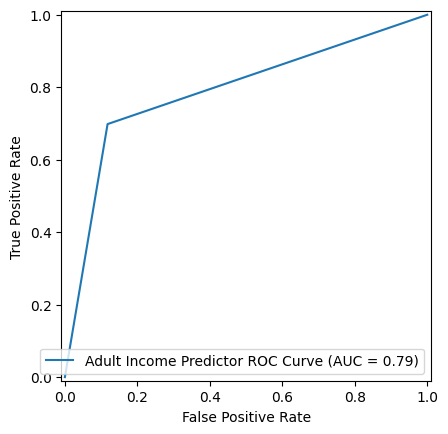

In [354]:
# Generate an ROC curve for your model.
other_false_positive_rate, other_true_positive_rate, other_thresholds = roc_curve (target_test, predictions)
draw_my_better_curve = RocCurveDisplay (\
  fpr = other_false_positive_rate,\
  tpr = other_true_positive_rate,\
  roc_auc = auc (other_false_positive_rate, other_true_positive_rate),\
  estimator_name = "Adult Income Predictor ROC Curve")
draw_my_better_curve.plot()

The most surprising part of this project for me was how little the neural network topology impacted the effectiveness of the model.  My more complex neural network did not always outperform my simpler one, but even when it did, it was not by much.

The choice of optimizer for my neural networks was difficult and made a huge difference in the results.  I noticed a difference of over 0.1 between 'adadelta' and 'adam' in the same network with the same number of epochs.  Knowing my chosen optimizer intuitively helped me make sense of the performance to each of my models.  ADAM fared better for my simpler model, but stochastic gradient descent made much of the AUC difference in my more complex one.

Activation functions have their place, but cramming one in each layer of a network creates unnecessary noise in the training process and leads to less accurate models.  Meaningful placement of activation functions in key layers yields better AUC scores for each model, in my experience.

Old rules of thumb do not apply like they used to, and knowing one's data is crucial to implementing a strong neural network for it.  The only best practice is, well, to practice: https://www.reddit.com/r/learnmachinelearning/comments/1fq6513/how_many_parameters_are_appropriate_for_a_neural/

I look forward to my next challenge.